In [7]:
!pip install langchain_openai --quiet
!pip install PyMuPDF --quiet

In [8]:
from google.colab import userdata
import os
github_token = userdata.get('GITHUB_TOKEN')
os.environ['GITHUB_TOKEN'] = github_token

In [20]:
from langchain_openai import ChatOpenAI
import pandas as pd
import fitz
import os

from langchain.docstore.document import Document
from langchain_openai import ChatOpenAI
from langchain.chains.summarize import load_summarize_chain

In [13]:
endpoint = "https://models.github.ai/inference"
model_name = "openai/gpt-4o-mini"

In [14]:
def extract_text_from_pdf(pdf_path):
    """Extract text from PDF using PyMuPDF."""
    doc = fitz.open(pdf_path)
    text = "".join([page.get_text() for page in doc])
    return text

In [15]:
resume1_pdf = '/content/ModifiedResume.pdf'
resume2_pdf = '/content/ModifiedResume2.pdf'

In [16]:
resume1_txt = extract_text_from_pdf(resume1_pdf)
resume1_txt

'CHETAN\nAddress: Bangalore, \nMobile No: +91-1234567809\nEmail: .cc@gmail.com \n                                                                                    PROFESSIONAL SUMMARY                                                                                         \n•\nSoftware Engineering professional with nearly 5.0 years of experience in Java Full Stack Technology, mainly \ninvolved inAnalysis and Development of enterprise grade application and Java based AI and ML project. \n•\nCurrently associated with Cardinal Health International India, as Full Stack Developer (from Oct 2021 \nto May 2022), with domain knowledge of Java, J2EE, Spring boot Framework, Node.js and angular 10. \n•\nHands-on experience in Spring boot, Spring Data JPA, Hibernate, JUnit, Bootstrap and Angular library. \n•\nAdept in end-to-end development of application software from requirement analysis to system study, \ndesigning, coding, testing, de-bugging, documentation & implementation. \n•\nSturdy knowl

In [24]:
resume2_txt = extract_text_from_pdf(resume2_pdf)
resume2_txt

'NITISH \nSENIOR SOFTWARE ENGINEER \nPreferred Locations: Bangalore, Pune, and \nHyderabad \n \n+91 1234557809 \nabc@gmail.com \nOBJECTIVE \nDedicated \nand \nresult-oriented \nprofessional with experience in \nleading and contributing to the \ndevelopment \nof \nsoftware \napplications, \ndesigning \nscalable \ndatabase structures and crafting \nresponsive \nuser \nexperiences. \nPursuing a challenging role to \nleverage \nexpertise \nin \nBack-end \ndevelopment to drive efficiency, \nquality, \nand \ninnovation \nin \na \ncollaborative team environment. \nEDUCATION \n2019 \nB.Tech. \nin \nElectronics \nand \nInstrumentation Engineering from \nNational Institute of Technology, \nSilchar, Assam with 7.3 CGPA \nCORE COMPETENCIES \n• Full-Stack Development \n• Software Development Lifecycle \n• Software \nDevelopment \nFramework (SDF) \n• Coaching, Mentoring \n• Requirement Gathering \n• Root Cause Analysis \nPROFILE SUMMARY \n• \nPossess nearly 5 years of experience in Full-stack Develo

In [21]:
docs = [Document(page_content=resume1_txt)]

In [22]:
llm_model = ChatOpenAI(
    base_url = endpoint,
    api_key= github_token,
    model=model_name
)

In [23]:
llm_model.get_num_tokens(resume1_txt) #5 pages document but token is very less

2353

In [25]:
llm_model.get_num_tokens(resume2_txt) #2 pages document

1637

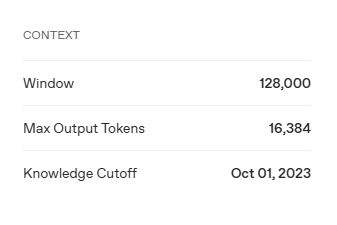

## Using StuffDocumentChain

In [26]:
from langchain import PromptTemplate

In [28]:
template = """
        Generate a professional summary of the entire resume with these important points:\n
        Start the precise summary with an introduction and provide the summary in number points with following details:\n
        Name: \n
        Most Recent Job Information - Organization, Job Title, Start Date, End Date: \n
        Job Responsibilities: \n
        Second Most Recent Job: - Organization, Job Title, Start Date, End Date: \n
        Job Responsibilities: \n
        Education: \n
        Hard Skills: \n
        Soft Skills: \n
        Tools: \n
        Projects:\n
        Other important information\n
        Resume: '{resume}'
    """

In [48]:
prompt = PromptTemplate(
    input_variables=['resume'],
    template=template
)

In [49]:
chain = load_summarize_chain(
    llm_model,
    chain_type='stuff',
    prompt=prompt,
    verbose=False,
    document_variable_name='resume'
)
output_summary = chain.invoke(docs)

In [50]:
from pprint import pprint
pprint(output_summary.get('output_text'))

('**Professional Summary of Chetan**\n'
 '\n'
 'Chetan is a Software Engineering professional with nearly 5 years of '
 'experience specializing in Java Full Stack Technology and projects '
 'concerning enterprise-grade applications, AI, and ML. Below is a detailed '
 'professional summary:\n'
 '\n'
 '1. **Name**: Chetan\n'
 '\n'
 '2. **Most Recent Job Information**: \n'
 '   - **Organization**: Cardinal Health International India Pvt Ltd \n'
 '   - **Job Title**: Full Stack Developer \n'
 '   - **Start Date**: October 2021 \n'
 '   - **End Date**: May 2022\n'
 '\n'
 '3. **Job Responsibilities**: \n'
 '   - Developed the mscripts application for the healthcare domain, involving '
 'multithreaded services and job scheduling.\n'
 '   - Designed user interfaces using Node.js and Angular, and created '
 'notifications and test cases for both client and server-side.\n'
 '\n'
 '4. **Second Most Recent Job**: \n'
 '   - **Organization**: Legato Health Technologies LLP  \n'
 '   - **Job Title*

## Using Map-Reduce

In [51]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [52]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=20)
chunks = text_splitter.create_documents([resume1_txt])

In [53]:
len(chunks)

2

In [74]:
map_template = """
        Generate a concise summary of the following document chunk:\n
        Document: '{text}'
        Summary:
    """

combine_template = """
        Combine the following summaries into a single, professional summary of the entire resume with these important points:\n
        Start the precise summary with an introduction and provide the summary in number points with following details:\n
        Name: \n
        Most Recent Job Information - Organization, Job Title, Start Date, End Date: \n
        Job Responsibilities: \n
        Second Most Recent Job: - Organization, Job Title, Start Date, End Date: \n
        Job Responsibilities: \n
        Education: \n
        Hard Skills: \n
        Soft Skills: \n
        Tools: \n
        Projects:\n
        Other important information\n
        Summaries: '{text}'
        Combined Summary:
    """

In [75]:
map_prompt = PromptTemplate(
    input_variables=['text'],
    template=map_template
)

combine_prompt = PromptTemplate(
    input_variables=['text'],
    template=combine_template
)

In [76]:
map_prompt

PromptTemplate(input_variables=['text'], input_types={}, partial_variables={}, template="\n        Generate a concise summary of the following document chunk:\n\n        Document: '{text}'\n        Summary:\n    ")

In [78]:
chain2 = load_summarize_chain(
    llm_model,
    chain_type='map_reduce',
    map_prompt=map_prompt,
    combine_prompt=combine_prompt,
    verbose=False,
)
output_summary2 = chain2.invoke(chunks)

In [80]:
from pprint import pprint
pprint(output_summary2.get('output_text'))

('**Professional Summary**\n'
 '\n'
 'Chetan is a dedicated software engineering professional with nearly 5 years '
 'of experience, specializing in Java Full Stack Technology, particularly in '
 'enterprise applications and AI/ML projects.\n'
 '\n'
 '1. **Name:** Chetan \n'
 '\n'
 '2. **Most Recent Job Information:** \n'
 '   - **Organization:** Cardinal Health International \n'
 '   - **Job Title:** Full Stack Developer \n'
 '   - **Start Date:** [Insert Start Date] \n'
 '   - **End Date:** [Insert End Date]\n'
 '\n'
 '   **Job Responsibilities:** \n'
 '   - Engaged in application development utilizing Agile methodologies.\n'
 '   - Worked on enterprise application development focusing on high-quality '
 'deliverables.\n'
 '   - Leveraged expertise in Java, J2EE, Spring Boot, Node.js, and Angular to '
 'handle both front-end and back-end projects.\n'
 '\n'
 '3. **Second Most Recent Job:** \n'
 '   - **Organization:** Legato Healthcare Technologies \n'
 '   - **Job Title:** Full Stack